# LSD1 Binding to ORY-1001 and GSK2879552 KDM1 Inhibitors
---

### Step 1: Download Ligand Structures from PubChem
In this step, we’ll download the structures for ORY-1001 and GSK2879552 from PubChem in SDF format. Each structure will be saved locally in a designated folder called `ligands`.

In [1]:
import requests  # Import requests for making HTTP requests
import os  # Import os for file and directory operations

# Define the PubChem CIDs for ORY-1001 and GSK2879552 ligands
ligands = {
    "ORY1001": 71543365,
    "GSK2879552": 66571643
}

# Create a directory called "ligands" if it does not already exist
os.makedirs("ligands", exist_ok=True)

# Loop through each ligand name and CID to download the structure file
for ligand_name, cid in ligands.items():
    # Construct the URL for fetching the SDF file of the ligand from PubChem
    sdf_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/SDF"

    # Send an HTTP GET request to download the ligand structure
    response = requests.get(sdf_url)

    # Check if the download was successful (status code 200)
    if response.status_code == 200:
        # Write the downloaded content to a file in the "ligands" directory
        with open(f"ligands/{ligand_name.lower()}.sdf", "wb") as file:
            file.write(response.content)
        print(
            f"Ligand {ligand_name} saved as ligands/{ligand_name.lower()}.sdf")
    else:
        # Print an error message if the download was not successful
        print(f"Failed to download {
              ligand_name}. Status code:", response.status_code)

Ligand ORY1001 saved as ligands/ory1001.sdf
Ligand GSK2879552 saved as ligands/gsk2879552.sdf


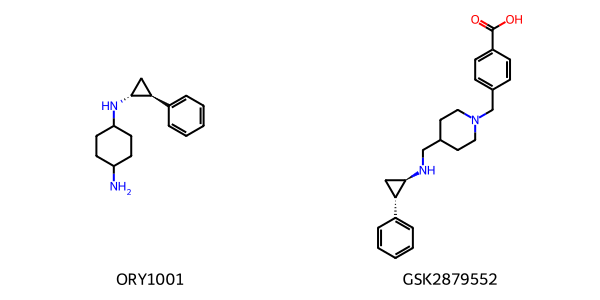

In [2]:
# Import necessary libraries from RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display  # for displaying images in Jupyter Notebook

# Function to visualize 2D structures of ligands


def visualize_ligands_2D(ligands):
    """
    Generates and displays 2D structures for each ligand in the list.

    Args:
        ligands (dict): Dictionary containing ligand names as keys and file paths as values.
    """
    # List to hold RDKit molecule objects for drawing
    mols = []

    for ligand_name, file_path in ligands.items():
        # Load the ligand from the SDF file
        mol = Chem.MolFromMolFile(file_path)

        # Check if molecule loaded successfully
        if mol is not None:
            mol.SetProp("_Name", ligand_name)  # Set the name for each molecule
            mols.append(mol)  # Add molecule to list for visualization
        else:
            print(f"Failed to load {ligand_name} for 2D visualization.")

    # Draw and display all molecules in a grid format
    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(
        300, 300), legends=[mol.GetProp("_Name") for mol in mols])
    display(img)  # Show the 2D structure image


# Call the function to visualize ligands in 2D
ligands_sdf_paths = {
    "ORY1001": "ligands/ory1001.sdf",
    "GSK2879552": "ligands/gsk2879552.sdf"
}
visualize_ligands_2D(ligands_sdf_paths)

### Step 2: Optimize Ligand Structures
Using RDKit, we’ll load the SDF files, add hydrogens to each molecule, and optimize their 3D structures. The optimized structures will be saved in PDB format.

In [3]:
from rdkit import Chem  # Import RDKit Chem module for molecular operations
from rdkit.Chem import AllChem # Import RDKit AllChem module for embedding molecules

# Define file paths for ligands
ligands = {
    "ORY1001": "ligands/ory1001.sdf",
    "GSK2879552": "ligands/gsk2879552.sdf"
}

# Loop through each ligand and file path for processing
for ligand_name, sdf_path in ligands.items():
    # Load the molecule from the SDF file
    mol = Chem.MolFromMolFile(sdf_path)

    # Check if the molecule was loaded successfully
    if mol is not None:
        mol = Chem.AddHs(mol)  # Add hydrogen atoms to the molecule

        # Attempt to embed the molecule in 3D space and optimize it
        try:
            # Embed molecule in 3D
            AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
            # Optimize structure with UFF force field
            AllChem.UFFOptimizeMolecule(mol)

            # Define the output path for the optimized PDB file
            pdb_path = f"ligands/{ligand_name.lower()}_optimized.pdb"

            # Save the optimized molecule in PDB format
            Chem.MolToPDBFile(mol, pdb_path)
            print(f"Ligand {ligand_name} optimized and saved as {pdb_path}")
        except Exception as e:
            # Print an error message if embedding or optimization fails
            print(f"Optimization failed for {ligand_name}: {e}")
    else:
        # Print an error message if the molecule cannot be loaded
        print(f"Failed to load {ligand_name} from {sdf_path}")

Ligand ORY1001 optimized and saved as ligands/ory1001_optimized.pdb
Ligand GSK2879552 optimized and saved as ligands/gsk2879552_optimized.pdb


In [4]:
# Import py3Dmol for 3D visualization
import py3Dmol

# Function to visualize optimized ligands in 3D


def visualize_optimized_ligand_3D(file_path):
    """
    Visualizes a ligand's optimized 3D structure from a PDB file.

    Args:
        file_path (str): Path to the PDB file of the optimized ligand.
    """
    # Initialize 3D viewer
    viewer = py3Dmol.view(width=400, height=400)

    # Read the PDB file
    with open(file_path, 'r') as pdb_file:
        pdb_data = pdb_file.read()

    # Add the molecule to the viewer
    viewer.addModel(pdb_data, "pdb")
    viewer.setStyle({"stick": {}})
    viewer.zoomTo()

    # Display the 3D structure
    return viewer.show()


# Paths to the optimized PDB files for the ligands
optimized_ligands = {
    "ORY1001": "ligands/ory1001_optimized.pdb",
    "GSK2879552": "ligands/gsk2879552_optimized.pdb"
}

# Visualize each optimized ligand in 3D
for ligand_name, pdb_path in optimized_ligands.items():
    print(f"3D structure for {ligand_name}:")
    visualize_optimized_ligand_3D(pdb_path)

3D structure for ORY1001:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3D structure for GSK2879552:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Ligand: ORY1001
Parent Structure (Scaffold):


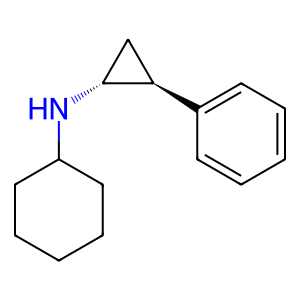


Identified R Groups:
Core:


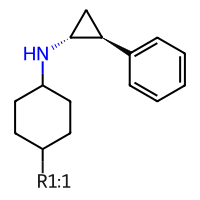

R1:


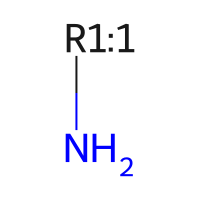


Ligand: GSK2879552
Parent Structure (Scaffold):


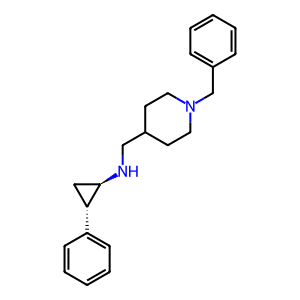


Identified R Groups:
Core:


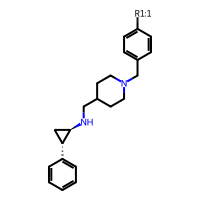

R1:


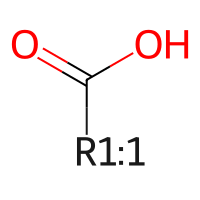

In [5]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.display import display

# Function to identify and display the parent scaffold and R groups


def identify_parent_and_r_groups(sdf_file):
    """
    Identifies and displays the parent structure (scaffold) and R groups of a ligand.

    Args:
        sdf_file (str): Path to the SDF file of the ligand.
    """
    # Load molecule from SDF file
    mol = Chem.MolFromMolFile(sdf_file)

    # Generate the core scaffold (Murcko Scaffold)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    print("Parent Structure (Scaffold):")
    display(Draw.MolToImage(scaffold, size=(300, 300)))

    # Perform R-group decomposition
    rgroups, unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold], [
                                                               mol])

    if rgroups and rgroups[0]:
        print("\nIdentified R Groups:")
        # Display each identified R group
        for label, group in rgroups[0].items():
            if group:  # Ensure group exists
                print(f"{label}:")
                display(Draw.MolToImage(group, size=(200, 200)))
    else:
        print("No distinct R groups identified for this molecule.")


# Paths to the SDF files for each ligand
ligand_files = {
    "ORY1001": "ligands/ory1001.sdf",
    "GSK2879552": "ligands/gsk2879552.sdf"
}

# Identify parent structure and R groups for each ligand
for ligand_name, sdf_path in ligand_files.items():
    print(f"\nLigand: {ligand_name}")
    identify_parent_and_r_groups(sdf_path)

### Step 3: Download Protein Structure from RCSB PDB
For docking, we need the target protein structure. Here, we’ll download the protein structure for LSD1 (PDB ID: 2UXX) and save it to a directory called `protein_structures`.

In [6]:
import requests  # Import requests for HTTP operations

# Define the PDB ID for LSD1 protein and the directory to save it
pdb_id = "2UXX"
protein_directory = "protein_structures"
# Create the directory if it doesn't exist
os.makedirs(protein_directory, exist_ok=True)

# Download the PDB file of the protein structure from the RCSB PDB website
pdb_request = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")

# Check if the download was successful
if pdb_request.status_code == 200:
    # Save the downloaded protein structure file in the specified directory
    with open(f"{protein_directory}/{pdb_id}.pdb", "w") as f:
        f.write(pdb_request.text)
    print(f"Downloaded {pdb_id} and saved to {protein_directory}/{pdb_id}.pdb")
else:
    # Print an error message if the download failed
    print(f"Failed to download protein structure. Status code:",
          pdb_request.status_code)

Downloaded 2UXX and saved to protein_structures/2UXX.pdb


In [7]:
# Import py3Dmol for protein visualization
import py3Dmol

# Define the path to the downloaded PDB file
protein_pdb_path = f"{protein_directory}/{pdb_id}.pdb"

# Load and display the protein structure using py3Dmol
with open(protein_pdb_path, "r") as file:
    pdb_content = file.read()  # Read the PDB file content

# Initialize the viewer
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_content, "pdb")  # Load the PDB content into the viewer
view.setStyle({"cartoon": {"color": "spectrum"}})  # Display style for protein
view.zoomTo()  # Adjust view to focus on the entire protein
view.show()  # Display the viewer

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Step 4: Clean and Prepare Protein Structure
In this step, we’ll clean the downloaded protein structure by removing any extra molecules (such as water and ligands) and adding missing atoms and hydrogens. This prepares the protein for docking by ensuring it is in the correct state. We’ll use `pdbfixer` for this step

1. **Load the Protein:** We start by loading the PDB file for our protein using `pdbfixer`, a tool designed to fix common issues in protein structures.
2. **Remove Heterogens:** This command removes non-protein molecules from the structure. Here, we remove all water molecules and other non-standard residues.
3. **Add Missing Atoms and Hydrogens:** The protein may have missing atoms, especially hydrogens and side chains. We add these, setting the protonation state for a neutral pH of 7.4.
4. **Save the Cleaned Protein:** The cleaned protein structure is saved to a new file for the next steps.

This process ensures that the protein is in the optimal condition for docking calculations in Step 6.

In [ ]:
import os
from tqdm import tqdm
import pdbfixer
from openmm.app import PDBFile

# Define paths
protein_path = "protein_structures/2UXX.pdb"
cleaned_protein_path = "protein_structures/2UXX_cleaned.pdb"

# Check if cleaned protein file already exists
if os.path.exists(cleaned_protein_path):
    print(f"{cleaned_protein_path} already exists. Skipping cleaning step.")
else:
    # Initialize tqdm for progress tracking
    with tqdm(total=5, desc="Cleaning Protein Structure") as progress:
        
        # Load the protein structure file into pdbfixer
        fixer = pdbfixer.PDBFixer(filename=protein_path)
        progress.update(1)  # Step 1: Loaded structure file
        
        # Remove water molecules and any non-standard residues
        fixer.removeHeterogens(keepWater=False)
        progress.update(1)  # Step 2: Removed heterogens
        
        # Add missing atoms and residues
        fixer.findMissingResidues()
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        progress.update(1)  # Step 3: Added missing residues and atoms
        
        # Add missing hydrogens at pH 7.4
        fixer.addMissingHydrogens(pH=7.4)
        progress.update(1)  # Step 4: Added missing hydrogens

        # Save the cleaned structure
        with open(cleaned_protein_path, 'w') as outfile:
            PDBFile.writeFile(fixer.topology, fixer.positions, outfile)
        progress.update(1)  # Step 5: Saved cleaned structure
        
    print(f"Cleaned protein saved as {cleaned_protein_path}")


In [ ]:
import nglview as nv
import py3Dmol

# Load a sample molecule, for example, a pre-installed protein or local pdb file
view = nv.show_structure_file("protein_structures/2UXX_cleaned.pdb")

# Display the molecule
view


### Step 5: Convert Protein to PDBQT Format
AutoDock Vina requires both the protein and ligands to be in `PDBQT` format. We’ll use `Open Babel` to convert the cleaned protein structure to PDBQT.

In [ ]:
import os
import subprocess

# Paths for the input and output files
protein_pdb_path = "protein_structures/2UXX_cleaned.pdb"
protein_pdbqt_path = "protein_structures/2UXX_cleaned.pdbqt"

# Function to convert the cleaned protein PDB to PDBQT format


def convert_protein_to_pdbqt(input_path, output_path):
    try:
        # Use Open Babel to convert PDB to PDBQT, adding partial charges
        subprocess.run(["obabel", input_path, "-O", output_path,
                       "--partialcharge"], check=True)
        print(f"Converted protein {input_path} to {output_path}")
    except subprocess.CalledProcessError:
        print(f"Failed to convert {input_path} to {output_path}")


# Convert protein if the PDBQT file doesn’t already exist
if not os.path.exists(protein_pdbqt_path):
    print("Starting protein conversion...")
    convert_protein_to_pdbqt(protein_pdb_path, protein_pdbqt_path)
else:
    print(f"Protein PDBQT file already exists at {protein_pdbqt_path}")

### Step 6: Convert Ligands to PDBQT Format
To prepare ligands for AutoDock Vina, we’ll use `OpenBabel` to convert the optimized ligands to `PDBQT` format.

In [ ]:
# Import necessary libraries
import subprocess

# Function to prepare a ligand for docking using Open Babel


def prepare_ligand_for_docking(input_pdb_file: str, output_pdbqt_file: str) -> None:
    """
    Prepares a ligand for docking using Open Babel.

    Args:
        input_pdb_file (str): Path to the input PDB file of the ligand.
        output_pdbqt_file (str): Path to the output PDBQT file for docking.
    """
    # Use Open Babel to convert the input PDB file to PDBQT format
    # Open Babel command: obabel input.pdb -O output.pdbqt --gen3d
    try:
        subprocess.run([
            "obabel", input_pdb_file, "-O", output_pdbqt_file, "--gen3d"
        ], check=True)
        print(f"Ligand preparation complete. Output saved to {
              output_pdbqt_file}")
    except subprocess.CalledProcessError as e:
        print(f"Error during ligand preparation: {e}")


# Input PDB files for the ligands
input_ligand_files = [
    "ligands/ory1001_optimized.pdb",
    "ligands/gsk2879552_optimized.pdb"
]

# Loop through each ligand file and prepare it for docking
for input_file in input_ligand_files:
    # Derive the output filename by replacing the extension
    output_file = input_file.replace(".pdb", ".pdbqt")

    # Prepare the ligand using Open Babel
    prepare_ligand_for_docking(input_file, output_file)

### Step 7: Verify Prepared Files
Finally, let’s check if all files are correctly prepared for docking. This should include:
- `protein_structures/2UXX_cleaned.pdbqt`
- `ligands/ORY1001.pdbqt`
- `ligands/GSK2879552.pdbqt`

In [ ]:
# Run AutoDock Vina directly in Jupyter cell
!vina --config config.txt --out output_docked.pdbqt


In [ ]:
# Run this in a terminal or Jupyter notebook cell with `!` prefix
!pdb2pqr --pdb-output=protein_structures/protein_h.pdb --pH=7.4 protein_structures/2UXX.pdb protein_structures/2UXX.pqr --whitespace


In [ ]:
import nglview as nv
from rdkit import Chem
from rdkit.Chem import AllChem

# Load the SDF file for ORY-1001
ligand = Chem.MolFromMolFile("ligands/ory1001.sdf")

# Add hydrogens and optimize the geometry
ligand = Chem.AddHs(ligand)
AllChem.EmbedMolecule(ligand)
AllChem.UFFOptimizeMolecule(ligand)

# Save the ligand as a PDB file for visualization
Chem.MolToPDBFile(ligand, "ligands/ory1001.pdb")

# Use NGLView to visualize the molecule
view = nv.show_file("ligands/ory1001.pdb")  # Load the saved PDB file
view.add_ball_and_stick()  # Set the visualization style to "ball and stick"
view